In [7]:
import os
# 0 = all logs, 1 = filter out INFO, 2 = filter out WARNING, 3 = filter out ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [8]:
import tensorflow as tf

In [9]:
# --- 1. GPU config ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.debugging.set_log_device_placement(False)
else:
    print("No GPU found!")

In [10]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [11]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [12]:
# Path to the directory you want to check
folder_path = '/kaggle/input/coco-image-caption/train2014/train2014'

# List of file names in the directory
file_list = os.listdir(folder_path)
# Count the number of files
num_files = len(file_list)

print(f"There are {num_files} files in the directory {folder_path}")

There are 82783 files in the directory /kaggle/input/coco-image-caption/train2014/train2014


In [13]:
image_folder_path = '/kaggle/input/coco-image-caption/train2014/train2014'
caption_folder_path = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations'

In [14]:
captions_train = []
caption_file_path = os.path.join(caption_folder_path, 'captions_train2014.json')

with open(caption_file_path, 'r') as file:
    captions_train = json.load(file)

In [15]:
file_names = []
image_ids = []
captions = []

annotations = captions_train['annotations']
images=captions_train['images']

# Create a dictionary to map image_id to file_name
image_id_to_filename = {image['id']: image['file_name'] for image in images}

# Initialize empty lists to store the data
image_ids = []
captions = []
file_names = []

# Loop through the list of annotations
for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        file_name = "/kaggle/input/coco-image-caption/train2014/train2014/" + image_id_to_filename[image_id]
        image_ids.append(image_id)
        captions.append(annotation['caption'])
        file_names.append(file_name)

# Create a pandas DataFrame using the extracted data
data_train = {
    'image_id': image_ids,
    'image': file_names,
    'caption': captions

}

data_train = pd.DataFrame(data_train)

In [16]:
data_train

image_id                                              image  \
0         318556  /kaggle/input/coco-image-caption/train2014/tra...   
1         116100  /kaggle/input/coco-image-caption/train2014/tra...   
2         318556  /kaggle/input/coco-image-caption/train2014/tra...   
3         116100  /kaggle/input/coco-image-caption/train2014/tra...   
4         379340  /kaggle/input/coco-image-caption/train2014/tra...   
...          ...                                                ...   
414108    133071  /kaggle/input/coco-image-caption/train2014/tra...   
414109    410182  /kaggle/input/coco-image-caption/train2014/tra...   
414110    180285  /kaggle/input/coco-image-caption/train2014/tra...   
414111    133071  /kaggle/input/coco-image-caption/train2014/tra...   
414112    133071  /kaggle/input/coco-image-caption/train2014/tra...   

                                                  caption  
0          A very clean and well decorated empty bathroom  
1       A panoramic view of a kitchen and all of its a...  
2       A blue and white bathroom with butterfly theme...  
3          A panoramic photo of a kitchen and dining room  
4       A graffiti-ed stop sign across the street from...  
...                                                   ...  
414108  a slice of bread is covered with a sour cream ...  
414109  A long plate hold some fries with some sliders...  
414110       Two women sit and pose with stuffed animals.  
414111  White Plate with a lot of guacamole and an ext...  
414112      A dinner plate has a lemon wedge garnishment.  

[414113 rows x 3 columns]

In [17]:
captions_val = []

with open('/kaggle/input/coco-val2014-nb/annotations/captions_val2014.json', 'r') as file:
    captions_val = json.load(file)

In [18]:
file_names = []
image_ids = []
captions = []

annotations = captions_val['annotations']
images=captions_val['images']

# Create a dictionary to map image_id to file_name
image_id_to_filename = {image['id']: image['file_name'] for image in images}

# Initialize empty lists to store the data
image_ids = []
captions = []
file_names = []

# Loop through the list of annotations
for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        file_name = "/kaggle/input/coco-val2014-nb/val2014/" + image_id_to_filename[image_id]
        image_ids.append(image_id)
        captions.append(annotation['caption'])
        file_names.append(file_name)

# Create a pandas DataFrame using the extracted data
data_val = {
    'image_id': image_ids,
    'image': file_names,
    'caption': captions

}

data_val = pd.DataFrame(data_val)

In [19]:
data_val

image_id                                              image  \
0         203564  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
1         179765  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
2         322141  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
3          16977  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
4         106140  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
...          ...                                                ...   
202649    401092  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
202650    401092  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
202651    555904  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
202652      6177  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
202653     47720  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   

                                                  caption  
0       A bicycle replica with a clock as the front wh...  
1       A black Honda motorcycle parked in front of a ...  
2       A room with blue walls and a white sink and door.  
3       A car that seems to be parked illegally behind...  
4       A large passenger airplane flying through the ...  
...                                                   ...  
202649     A plate of food and a beverage are on a table.  
202650  This is an open faced sandwich with several co...  
202651   People eating in a restaurant near wine bottles.  
202652  The scissors with black handles are sitting open.  
202653  a cup of coffee sits next to a panini sandwich...  

[202654 rows x 3 columns]

In [20]:
captions_val_2017 = []

with open('/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json', 'r') as file:
    captions_val_2017 = json.load(file)

In [21]:
file_names = []
image_ids = []
captions = []

annotations = captions_val_2017['annotations']
images=captions_val_2017['images']

# Create a dictionary to map image_id to file_name
image_id_to_filename = {image['id']: image['file_name'] for image in images}

# Initialize empty lists to store the data
image_ids = []
captions = []
file_names = []

# Loop through the list of annotations
for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        file_name = "/kaggle/input/coco-image-caption/val2017/val2017/" + image_id_to_filename[image_id]
        image_ids.append(image_id)
        captions.append(annotation['caption'])
        file_names.append(file_name)

# Create a pandas DataFrame using the extracted data
data_val_2017 = {
    'image_id': image_ids,
    'image': file_names,
    'caption': captions

}

data_val_2017 = pd.DataFrame(data_val_2017)

In [22]:
data_val_2017

image_id                                              image  \
0        179765  /kaggle/input/coco-image-caption/val2017/val20...   
1        179765  /kaggle/input/coco-image-caption/val2017/val20...   
2        190236  /kaggle/input/coco-image-caption/val2017/val20...   
3        331352  /kaggle/input/coco-image-caption/val2017/val20...   
4        517069  /kaggle/input/coco-image-caption/val2017/val20...   
...         ...                                                ...   
25009      9590  /kaggle/input/coco-image-caption/val2017/val20...   
25010     84664  /kaggle/input/coco-image-caption/val2017/val20...   
25011    331569  /kaggle/input/coco-image-caption/val2017/val20...   
25012    231237  /kaggle/input/coco-image-caption/val2017/val20...   
25013    386134  /kaggle/input/coco-image-caption/val2017/val20...   

                                                 caption  
0      A black Honda motorcycle parked in front of a ...  
1          A Honda motorcycle parked in a grass driveway  
2      An office cubicle with four different types of...  
3              A small closed toilet in a cramped space.  
4         Two women waiting at a bench next to a street.  
...                                                  ...  
25009  A group of men sipping drinks and talking at a...  
25010  A plate of food with some eggs, potatoes, brea...  
25011  The strawberries was sitting beside the tall g...  
25012  A bunch of small red flowers in a barnacle enc...  
25013         Food is in a styrofoam take out container.  

[25014 rows x 3 columns]

In [23]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size)) 
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(temp_df.image[i])
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [24]:
directory_path = "/kaggle/input/coco-image-caption/train2014/train2014"
file_list = os.listdir(directory_path)
# Tạo danh sách đường dẫn đầy đủ
file_list_fullpath = [os.path.join(directory_path, f) for f in file_list]
data_train = data_train[data_train["image"].isin(file_list_fullpath)]

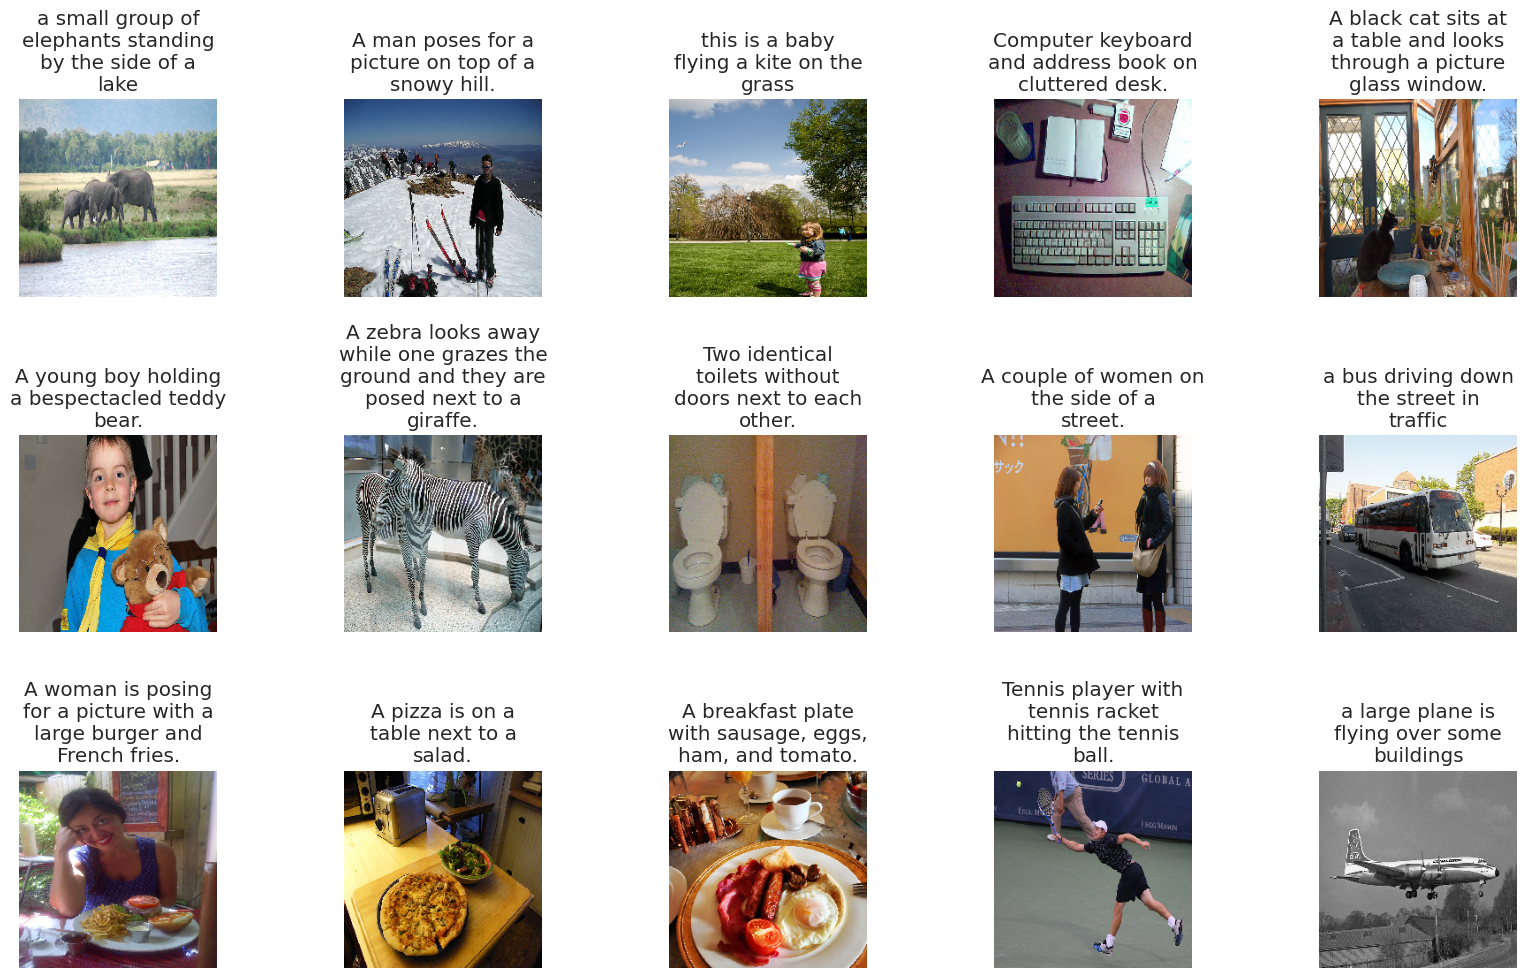

In [25]:
display_images(data_train.sample(15))

In [26]:
directory_path = "/kaggle/input/coco-val2014-nb/val2014/"
file_list = os.listdir(directory_path)
# Tạo danh sách đường dẫn đầy đủ
file_list_fullpath = [os.path.join(directory_path, f) for f in file_list]
data_val = data_val[data_val["image"].isin(file_list_fullpath)]

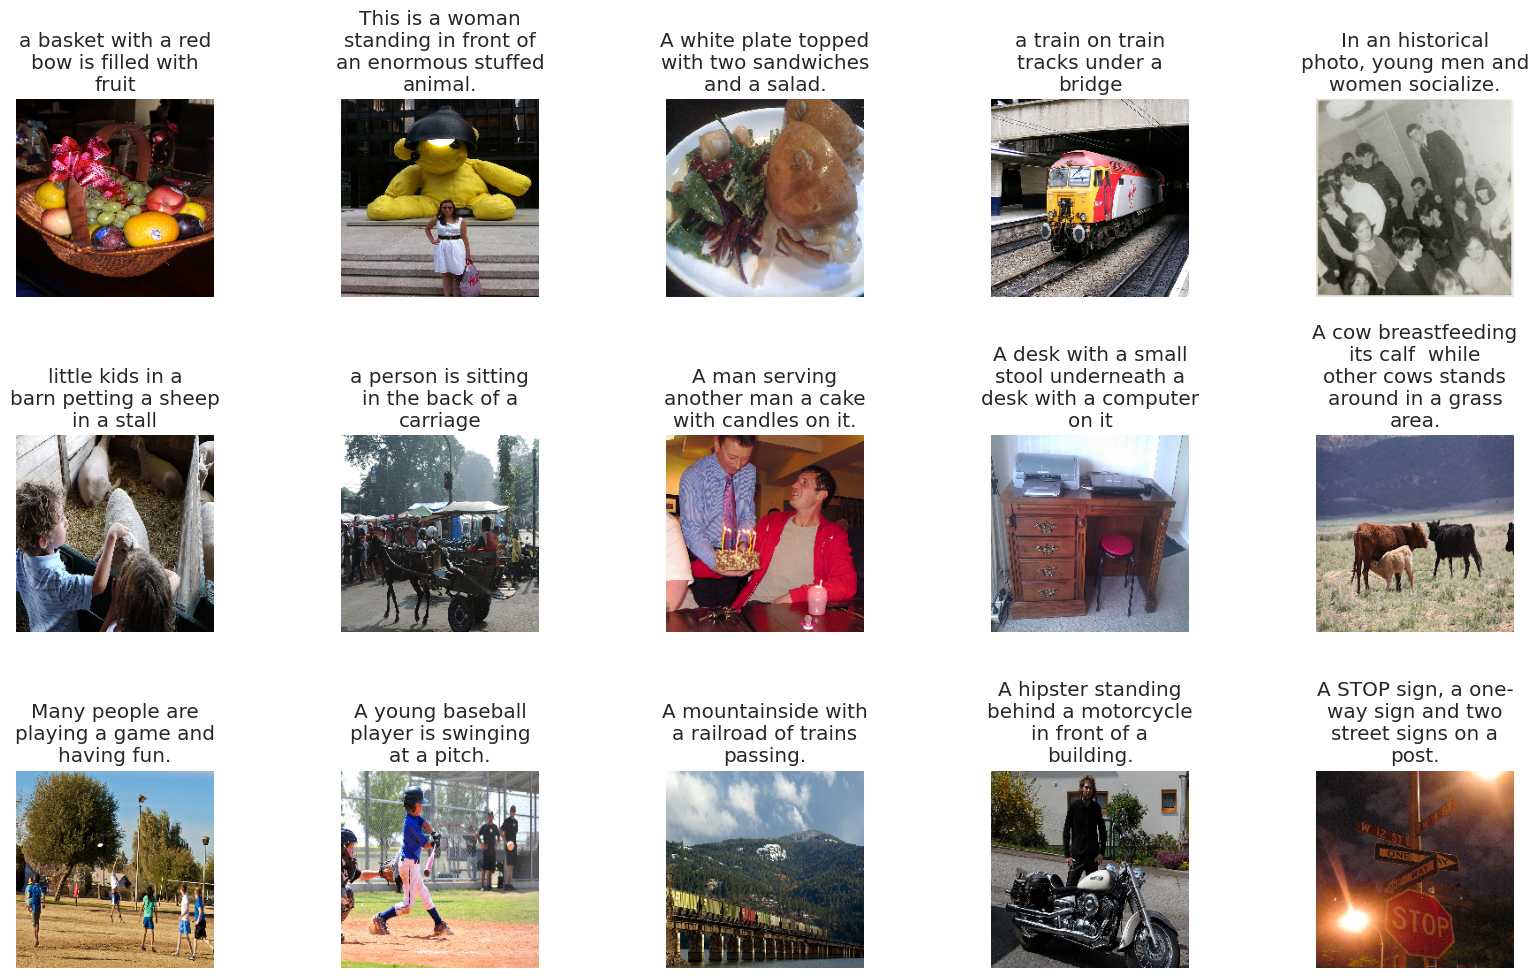

In [27]:
display_images(data_val.sample(15))

In [28]:
directory_path = "/kaggle/input/coco-image-caption/val2017/val2017"
file_list = os.listdir(directory_path)
# Tạo danh sách đường dẫn đầy đủ
file_list_fullpath = [os.path.join(directory_path, f) for f in file_list]
data_val_2017 = data_val_2017[data_val_2017["image"].isin(file_list_fullpath)]

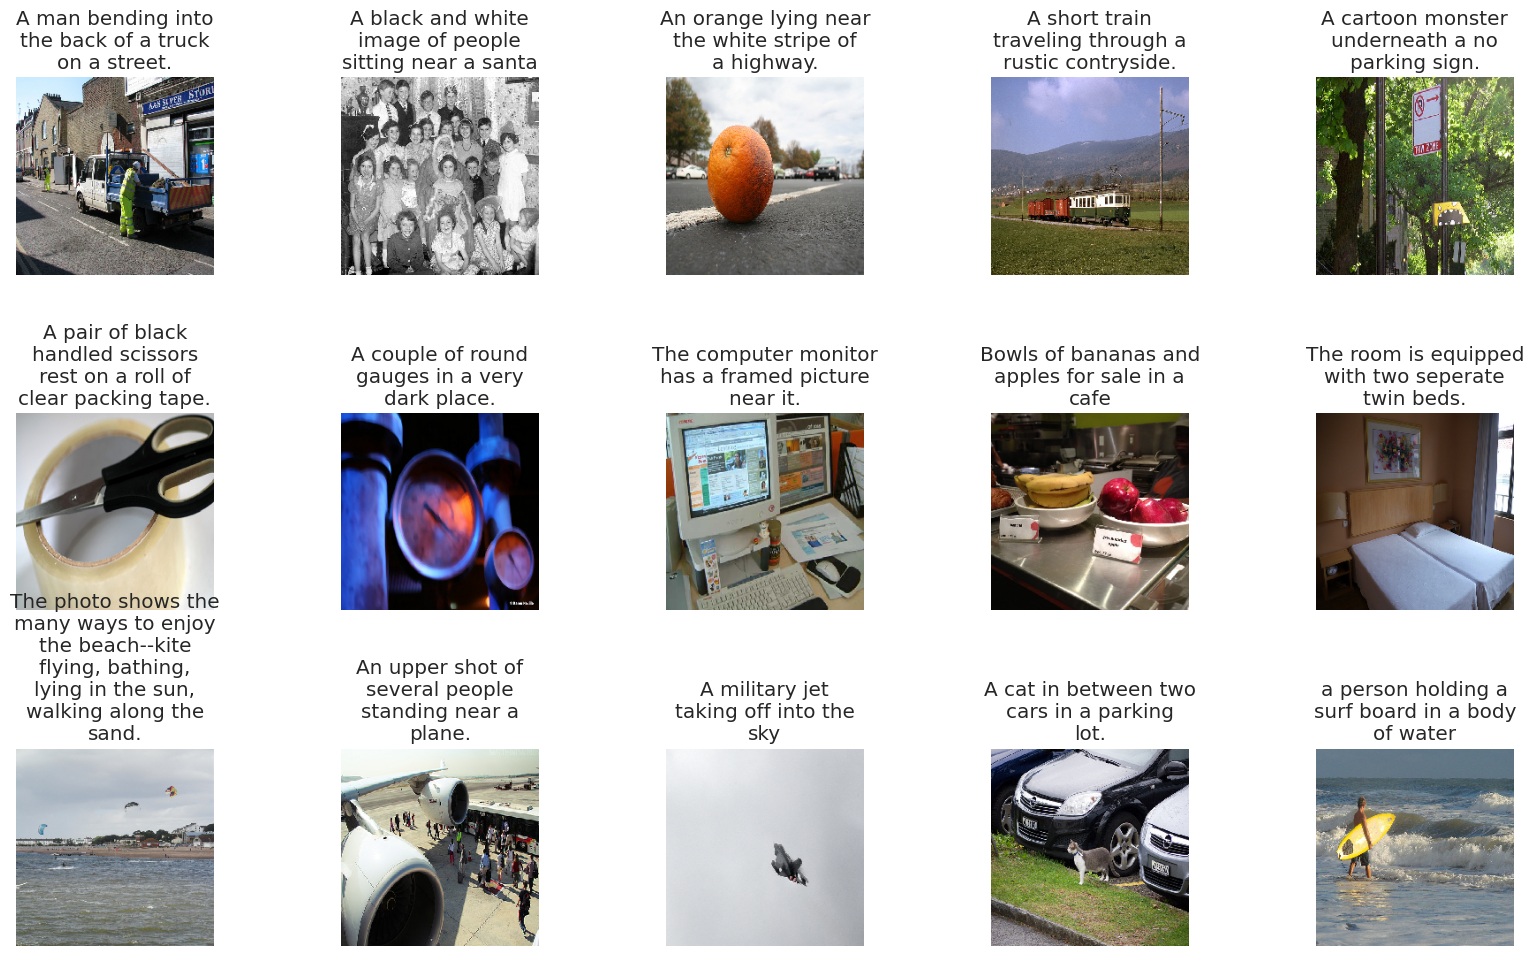

In [29]:
display_images(data_val_2017.sample(15))

In [30]:
import re

In [31]:
def text_preprocessing(data):
    # 1. Chuyển về chữ thường
    s = data['caption'].str.lower()
    
    # 2. Loại bỏ ký tự không phải chữ cái (giữ khoảng trắng)
    s = s.str.replace(r'[^a-zA-Z\s]', '', regex=True)
    
    # 3. Ghép nhiều khoảng trắng liên tiếp thành 1
    s = s.str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # 4. Chỉ giữ các từ có độ dài ≥2: findall lấy ra list các từ phù hợp, sau đó join
    s = s.str.findall(r'\b[a-zA-Z]{2,}\b').str.join(' ')
    
    # 5. Thêm startseq/endseq
    s = 'startseq ' + s + ' endseq'
    
    data['caption'] = s
    return data


In [32]:
!pip install -q visualkeras

In [33]:
# Giả sử bạn có 3 DataFrame: data_train, data_val, data_test
data = pd.concat([data_train, data_val, data_val_2017], ignore_index=True)

In [34]:
data

image_id                                              image  \
0         318556  /kaggle/input/coco-image-caption/train2014/tra...   
1         116100  /kaggle/input/coco-image-caption/train2014/tra...   
2         318556  /kaggle/input/coco-image-caption/train2014/tra...   
3         116100  /kaggle/input/coco-image-caption/train2014/tra...   
4         379340  /kaggle/input/coco-image-caption/train2014/tra...   
...          ...                                                ...   
641776      9590  /kaggle/input/coco-image-caption/val2017/val20...   
641777     84664  /kaggle/input/coco-image-caption/val2017/val20...   
641778    331569  /kaggle/input/coco-image-caption/val2017/val20...   
641779    231237  /kaggle/input/coco-image-caption/val2017/val20...   
641780    386134  /kaggle/input/coco-image-caption/val2017/val20...   

                                                  caption  
0          A very clean and well decorated empty bathroom  
1       A panoramic view of a kitchen and all of its a...  
2       A blue and white bathroom with butterfly theme...  
3          A panoramic photo of a kitchen and dining room  
4       A graffiti-ed stop sign across the street from...  
...                                                   ...  
641776  A group of men sipping drinks and talking at a...  
641777  A plate of food with some eggs, potatoes, brea...  
641778  The strawberries was sitting beside the tall g...  
641779  A bunch of small red flowers in a barnacle enc...  
641780         Food is in a styrofoam take out container.  

[641781 rows x 3 columns]

In [35]:
data = data.drop_duplicates(subset='caption', keep='first').reset_index(drop=True)

In [36]:
data

image_id                                              image  \
0         318556  /kaggle/input/coco-image-caption/train2014/tra...   
1         116100  /kaggle/input/coco-image-caption/train2014/tra...   
2         318556  /kaggle/input/coco-image-caption/train2014/tra...   
3         116100  /kaggle/input/coco-image-caption/train2014/tra...   
4         379340  /kaggle/input/coco-image-caption/train2014/tra...   
...          ...                                                ...   
593963    401092  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
593964    401092  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
593965    555904  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
593966      6177  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
593967     47720  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   

                                                  caption  
0          A very clean and well decorated empty bathroom  
1       A panoramic view of a kitchen and all of its a...  
2       A blue and white bathroom with butterfly theme...  
3          A panoramic photo of a kitchen and dining room  
4       A graffiti-ed stop sign across the street from...  
...                                                   ...  
593963     A plate of food and a beverage are on a table.  
593964  This is an open faced sandwich with several co...  
593965   People eating in a restaurant near wine bottles.  
593966  The scissors with black handles are sitting open.  
593967  a cup of coffee sits next to a panini sandwich...  

[593968 rows x 3 columns]

In [37]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq very clean and well decorated empty bathroom endseq',
 'startseq panoramic view of kitchen and all of its appliances endseq',
 'startseq blue and white bathroom with butterfly themed wall tiles endseq',
 'startseq panoramic photo of kitchen and dining room endseq',
 'startseq graffitied stop sign across the street from red car endseq',
 'startseq vandalized stop sign and red beetle on the road endseq',
 'startseq bathroom with border of butterflies and blue paint on the walls above it endseq',
 'startseq an angled view of beautifully decorated bathroom endseq',
 'startseq the two people are walking down the beach endseq',
 'startseq sink and toilet inside small bathroom endseq']

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

In [39]:
images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [40]:
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 3847, 159, 4, 59, 8, 310, 4, 105, 612, 2]

In [41]:
train

image_id                                              image  \
0         318556  /kaggle/input/coco-image-caption/train2014/tra...   
1         116100  /kaggle/input/coco-image-caption/train2014/tra...   
2         318556  /kaggle/input/coco-image-caption/train2014/tra...   
3         116100  /kaggle/input/coco-image-caption/train2014/tra...   
4         379340  /kaggle/input/coco-image-caption/train2014/tra...   
...          ...                                                ...   
507335    100547  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
507336    329088  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
507337     42215  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
507338    505636  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
507339    321692  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   

                                                  caption  
0       startseq very clean and well decorated empty b...  
1       startseq panoramic view of kitchen and all of ...  
2       startseq blue and white bathroom with butterfl...  
3       startseq panoramic photo of kitchen and dining...  
4       startseq graffitied stop sign across the stree...  
...                                                   ...  
507335  startseq two cheese burgers placed in box insi...  
507336  startseq snow skier with red back pack some mo...  
507337  startseq book teacup and vase stand behind thr...  
507338  startseq snowboarder makes jump above the snow...  
507339  startseq large group of horses tied to some po...  

[507340 rows x 3 columns]

In [42]:
test

image_id                                              image  \
0        581253  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
1        163575  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
2        331529  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
3        400062  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
4         12166  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
...         ...                                                ...   
86623    401092  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
86624    401092  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
86625    555904  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
86626      6177  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   
86627     47720  /kaggle/input/coco-val2014-nb/val2014/COCO_val...   

                                                 caption  
0      startseq zebra grazing on some grass near ston...  
1      startseq man and two dogs laying on top of bed...  
2      startseq woman seated near buckets and baskets...  
3      startseq man in brown shirt playing with red f...  
4      startseq couple of horses grazing in grass fie...  
...                                                  ...  
86623  startseq plate of food and beverage are on tab...  
86624  startseq this is an open faced sandwich with s...  
86625  startseq people eating in restaurant near wine...  
86626  startseq the scissors with black handles are s...  
86627  startseq cup of coffee sits next to panini san...  

[86628 rows x 3 columns]

In [43]:
vgg16_model = VGG16(weights='imagenet', include_top=False)
vgg16_model.summary()  # To check the structure of the model

I0000 00:00:1746607466.995716     247 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746607466.996367     247 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tqdm import tqdm

import random

In [45]:
# with strategy.scope():
#     fe = Model(inputs=vgg16_model.input, outputs=vgg16_model.layers[-1].output)
    
#     img_size = 224
#     features_train = {}
    
#     # Get all unique image filenames
#     unique_images = data_train['image'].unique().tolist()
    
#     batch_size = 64  # thử 32, 64, 128 để tìm sweet spot với VRAM của bạn
    
#     for i in tqdm(range(0, len(unique_images), batch_size), desc="Extracting features"):
#         batch_imgs = []
#         batch_keys = unique_images[i:i+batch_size]
        
#         # Load & preprocess batch
#         for fname in batch_keys:
#             img_path = os.path.join(image_folder_path, fname)
#             img = load_img(img_path, target_size=(img_size, img_size))
#             img = img_to_array(img)
#             img = preprocess_input(img)
#             batch_imgs.append(img)
        
#         batch_array = np.stack(batch_imgs, axis=0)  # shape = (batch_size, 224, 224, 3)
        
#         # Single predict call cho cả batch
#         batch_feats = fe.predict(batch_array, verbose=0)
        
#         # Gán kết quả về dict
#         for fname, feat in zip(batch_keys, batch_feats):
#             features_train[fname] = feat


In [46]:
# with strategy.scope():

#     img_size = 224
#     features_val = {}
    
#     # Get all unique image filenames
#     unique_images = data_val['image'].unique().tolist()
    
#     batch_size = 64  # thử 32, 64, 128 để tìm sweet spot với VRAM của bạn
    
#     for i in tqdm(range(0, len(unique_images), batch_size), desc="Extracting features"):
#         batch_imgs = []
#         batch_keys = unique_images[i:i+batch_size]
        
#         # Load & preprocess batch
#         for fname in batch_keys:
#             img_path = os.path.join("/kaggle/input/coco-image-caption/val2017/val2017", fname)
#             img = load_img(img_path, target_size=(img_size, img_size))
#             img = img_to_array(img)
#             img = preprocess_input(img)
#             batch_imgs.append(img)
        
#         batch_array = np.stack(batch_imgs, axis=0)  # shape = (batch_size, 224, 224, 3)
        
#         # Single predict call cho cả batch
#         batch_feats = fe.predict(batch_array, verbose=0)
        
#         # Gán kết quả về dict
#         for fname, feat in zip(batch_keys, batch_feats):
#             features_val[fname] = feat


In [47]:
# import pickle

# # Lưu features_train
# with open('/kaggle/working/features_train.pkl', 'wb') as f:
#     pickle.dump(features_train, f)

# # Lưu features_val
# with open('/kaggle/working/features_val.pkl', 'wb') as f:
#     pickle.dump(features_val, f)


In [48]:
import pickle

with open('/kaggle/input/features-train2014-val2017-coco/features_train2014_val_2017/features_train.pkl', 'rb') as f:
    features_train = pickle.load(f)

with open('/kaggle/input/extract-features-val2014coco/features_val_2014.pkl', 'rb') as f:
    features_val = pickle.load(f)

with open('/kaggle/input/features-train2014-val2017-coco/features_train2014_val_2017/features_val.pkl', 'rb') as f:
    features_val_2017 = pickle.load(f)

In [49]:
features_all = {}
features_all.update(features_train)
features_all.update(features_val)
features_all.update(features_val_2017)

In [50]:
preview = []
for fname, feat in list(features_all.items())[:10]:  # lấy 10 dòng
    preview.append({
        'filename': fname,
        'shape': feat.shape,
        'sample_flat_5': feat.flatten()[:5]
    })

df_preview = pd.DataFrame(preview)
print(df_preview)

                          filename        shape  \
0  COCO_train2014_000000318556.jpg  (7, 7, 512)   
1  COCO_train2014_000000116100.jpg  (7, 7, 512)   
2  COCO_train2014_000000379340.jpg  (7, 7, 512)   
3  COCO_train2014_000000134754.jpg  (7, 7, 512)   
4  COCO_train2014_000000538480.jpg  (7, 7, 512)   
5  COCO_train2014_000000476220.jpg  (7, 7, 512)   
6  COCO_train2014_000000299675.jpg  (7, 7, 512)   
7  COCO_train2014_000000032275.jpg  (7, 7, 512)   
8  COCO_train2014_000000302443.jpg  (7, 7, 512)   
9  COCO_train2014_000000025470.jpg  (7, 7, 512)   

                     sample_flat_5  
0        [0.0, 0.0, 0.0, 0.0, 0.0]  
1        [0.0, 0.0, 0.0, 0.0, 0.0]  
2        [0.0, 0.0, 0.0, 0.0, 0.0]  
3  [0.0, 0.0, 0.0, 0.0, 20.932352]  
4        [0.0, 0.0, 0.0, 0.0, 0.0]  
5        [0.0, 0.0, 0.0, 0.0, 0.0]  
6  [0.0, 0.0, 0.0, 0.0, 7.6821184]  
7  [0.0, 0.0, 0.0, 4.4360514, 0.0]  
8        [0.0, 0.0, 0.0, 0.0, 0.0]  
9        [0.0, 0.0, 0.0, 0.0, 0.0]  


In [51]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            img_name = image.split('/')[-1]
            feature = self.features[img_name]
            if feature.ndim == 4:
                feature = feature[0]  # Đảm bảo shape là (7, 7, 512)

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [52]:
train_generator = CustomDataGenerator(df=train, 
                                      X_col='image', 
                                      y_col='caption', 
                                      batch_size=128, 
                                      tokenizer=tokenizer, 
                                      vocab_size=vocab_size, 
                                      max_length=max_length, 
                                      features=features_all)

validation_generator = CustomDataGenerator(df=test, 
                                           X_col='image', 
                                           y_col='caption', 
                                           batch_size=128, 
                                           tokenizer=tokenizer, 
                                           vocab_size=vocab_size, 
                                           max_length=max_length, 
                                           features=features_all)


In [53]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

In [54]:

# # Feature extractor model
# input_a = Input(shape=(7, 7, 512))
# a1 = GlobalAveragePooling2D()(input_a)
# a2 = Dense(256, activation='relu')(a1)

# # Sequence model
# input_b = Input(shape=(max_length,))
# b1 = Embedding(vocab_size, 256)(input_b)
# b2 = LSTM(256)(b1)

# # Decoder model
# decoder1 = add([a2, b2])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# # Tie it together [image, seq] [word]
# model = Model(inputs=[input_a, input_b], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

# Nhánh ảnh
input_a = Input(shape=(7, 7, 512))
a1 = GlobalAveragePooling2D()(input_a)
a2 = Dense(256, activation='relu')(a1)
a2 = Dropout(0.3)(a2)  # 👈 Dropout sau Dense ảnh

# Nhánh caption
input_b = Input(shape=(max_length,))
b1 = Embedding(vocab_size, 256)(input_b)
b2 = LSTM(256)(b1)
b2 = Dropout(0.3)(b2)  # 👈 Dropout sau LSTM

# Decoder
decoder1 = add([a2, b2])
decoder1 = Dropout(0.3)(decoder1)  # 👈 Dropout sau Add
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input_a, input_b], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

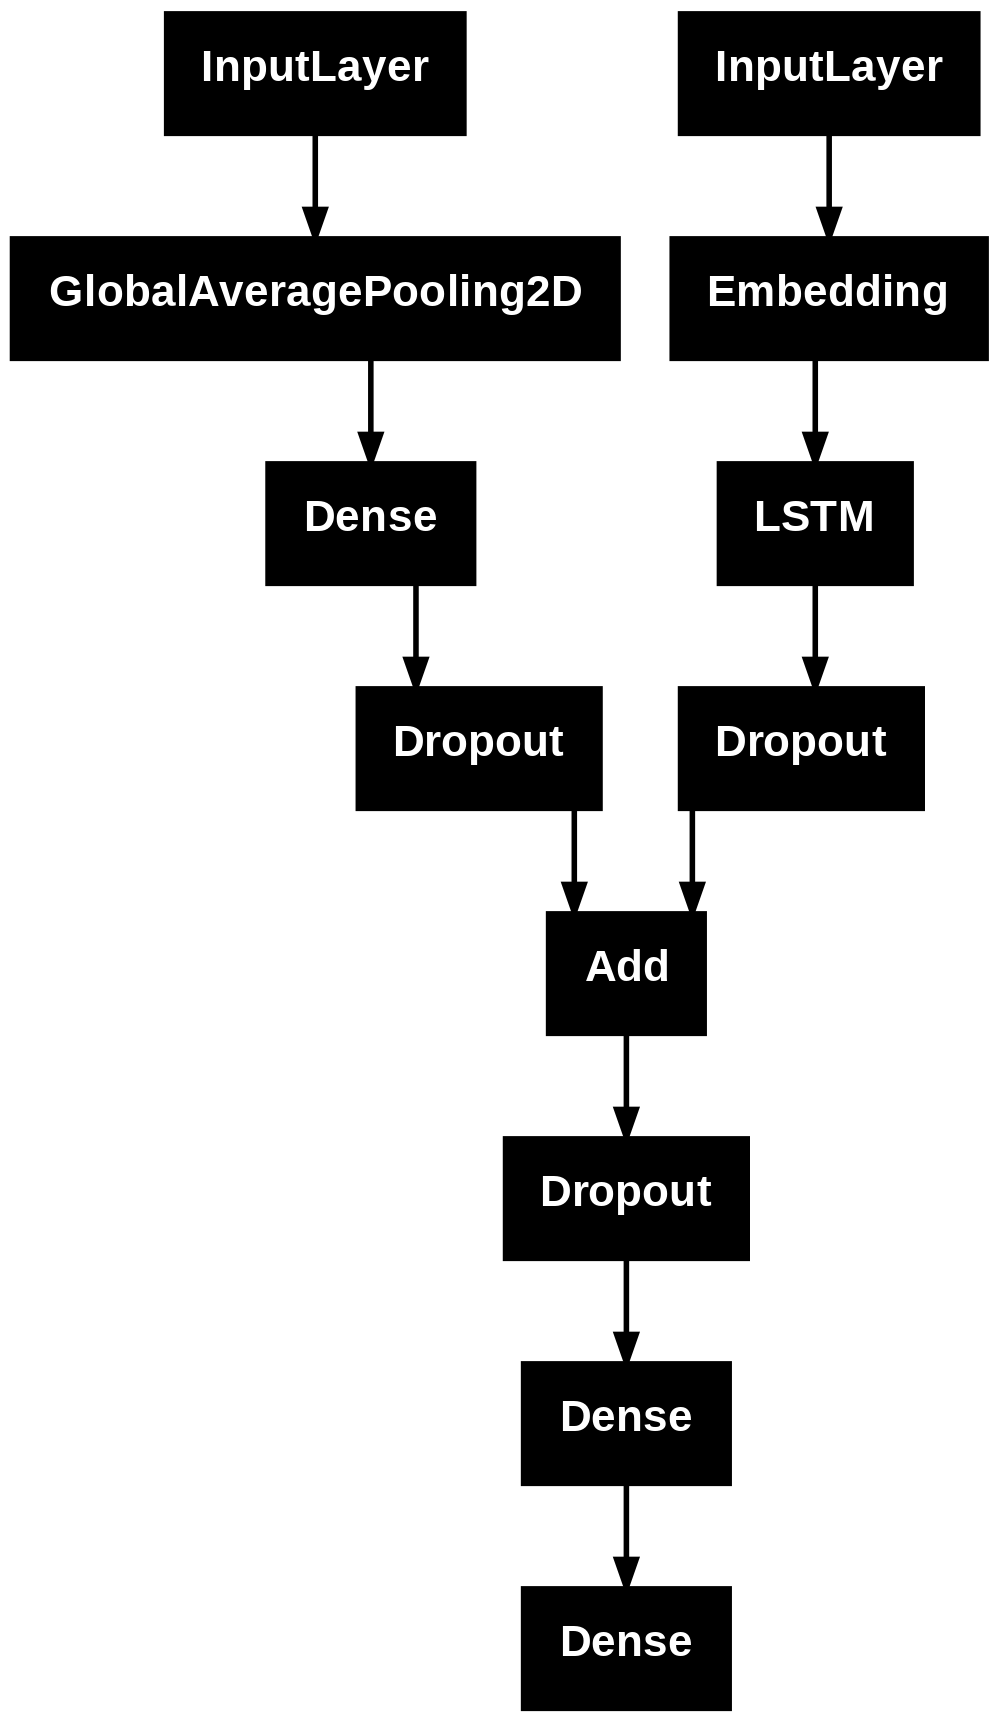

In [55]:
plot_model(model)

In [56]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 7, 7, 512)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 49)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ input_layer_1[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 49, 256)        │      7,438,848 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 29058)          │      7,467,906 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,629,186 (59.62 MB)

 Trainable params: 15,629,186 (59.62 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model_name = "model_AllDatavgg16.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [58]:
x, y = train_generator[0]
print("X types:", type(x), "len(x):", len(x))
print("X1 shape:", x[0].shape if isinstance(x, (list, tuple)) else "not list/tuple")
print("X2 shape:", x[1].shape if isinstance(x, (list, tuple)) else "not list/tuple")
print("y shape:", y.shape)


X types: <class 'tuple'> len(x): 2
X1 shape: (3274, 7, 7, 512)
X2 shape: (3274, 49)
y shape: (3274, 29058)


In [59]:
# Lấy một batch đầu tiên
sample_batch = train_generator[0]
model.predict(sample_batch[0])  # Warm-up model

 10/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

I0000 00:00:1746607564.960128     293 cuda_dnn.cc:529] Loaded cuDNN version 90300


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


array([[4.30012697e-05, 5.57339990e-05, 3.27089911e-05, ...,
        2.94753045e-05, 4.70723062e-05, 2.55829727e-05],
       [4.29910360e-05, 5.57405219e-05, 3.27231646e-05, ...,
        2.94880447e-05, 4.70621126e-05, 2.55800769e-05],
       [4.29859065e-05, 5.57733729e-05, 3.27315065e-05, ...,
        2.94775891e-05, 4.70656232e-05, 2.55623727e-05],
       ...,
       [7.35294598e-05, 3.97267613e-05, 3.82464859e-05, ...,
        1.48805475e-05, 4.75499219e-05, 2.36764899e-05],
       [7.35527574e-05, 3.97230833e-05, 3.82385151e-05, ...,
        1.48793797e-05, 4.75888046e-05, 2.36797405e-05],
       [7.35679350e-05, 3.97440090e-05, 3.82296676e-05, ...,
        1.48687841e-05, 4.75706438e-05, 2.36661672e-05]], dtype=float32)

In [60]:
history = model.fit(
        train_generator,
        epochs=2,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction]
)

Epoch 1/2
3963/3963 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.4771
Epoch 1: val_loss improved from inf to 3.38563, saving model to model_AllDatavgg16.keras
3963/3963 ━━━━━━━━━━━━━━━━━━━━ 5682s 1s/step - loss: 4.4770 - val_loss: 3.3856 - learning_rate: 0.0010
Epoch 2/2
3963/3963 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - loss: 3.3495
Epoch 2: val_loss improved from 3.38563 to 3.19428, saving model to model_AllDatavgg16.keras
3963/3963 ━━━━━━━━━━━━━━━━━━━━ 2979s 750ms/step - loss: 3.3495 - val_loss: 3.1943 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


In [63]:
def generate_caption_from_feature(model, tokenizer, feature, max_length):
    if feature.ndim == 4:
        feature = feature[0]
    feature = np.expand_dims(feature, axis=0)

    in_text = 'startseq'
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([feature, seq], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_idx)

        if word is None or word == 'endseq':
            break
        in_text += ' ' + word

    return in_text.replace('startseq', '').strip()

In [65]:
img_name, feat = list(features_all.items())[10]
caption = generate_caption_from_feature(model, tokenizer, feat, max_length)
print(f"{img_name}: {caption}")

COCO_train2014_000000513461.jpg: man is riding wave on surfboard


In [72]:
fe = features_all['COCO_val2014_000000001353.jpg']
caption = generate_caption_from_feature(model, tokenizer, fe, max_length)
print(caption)

man is sitting on bench with his legs


In [68]:
from PIL import Image

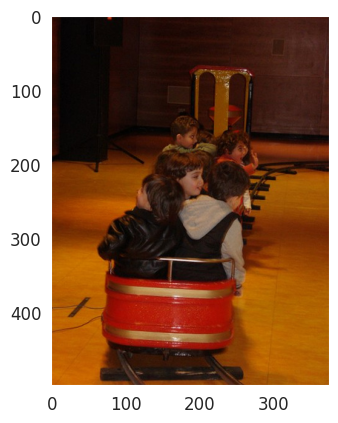

In [73]:
test_image = Image.open('/kaggle/input/coco-val2014-nb/val2014/COCO_val2014_000000001353.jpg')
plt.imshow(test_image)

In [102]:
# Giới hạn tối đa 20 ảnh
generated_captions = {}
for i, (img_name, feat) in enumerate(features_all.items()):
    if i >= 20:
        break
    feature_input = feat if feat.ndim == 4 else np.expand_dims(feat, axis=0)
    caption = generate_caption_from_feature(model, tokenizer, feature_input, max_length)
    t = img_name.split('_')[1]
    if t == 'train2014':
        path = '/kaggle/input/coco-image-caption/train2014/train2014/'
    elif t == 'val2014':
        path = '/kaggle/input/coco-val2014-nb/val2014/'
    else:
        path = '/kaggle/input/coco-image-caption/val2017/val2017/'
    generated_captions[path + img_name] = caption

# In ra kết quả
for img, cap in generated_captions.items():
    print(img, ":", cap)

/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000318556.jpg : bathroom with toilet and sink
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000116100.jpg : bathroom with toilet and sink
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000379340.jpg : stop sign is on the side of the road
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000134754.jpg : group of people standing on beach with kite
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000538480.jpg : bathroom with toilet and shower curtain
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000476220.jpg : kitchen with white appliances and white cabinets
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000299675.jpg : kitchen with stove and refrigerator
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000032275.jpg : bathroom with toilet and toilet
/kaggl

In [104]:
data[data['image'] == '/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000318556.jpg']

image_id                                              image  \
0      318556  /kaggle/input/coco-image-caption/train2014/tra...   
2      318556  /kaggle/input/coco-image-caption/train2014/tra...   
6      318556  /kaggle/input/coco-image-caption/train2014/tra...   
7      318556  /kaggle/input/coco-image-caption/train2014/tra...   
113    318556  /kaggle/input/coco-image-caption/train2014/tra...   

                                               caption  
0    startseq very clean and well decorated empty b...  
2    startseq blue and white bathroom with butterfl...  
6    startseq bathroom with border of butterflies a...  
7    startseq an angled view of beautifully decorat...  
113  startseq clock that blends in with the wall ha...

In [92]:
# # --- Ví dụ áp dụng cho cả dict features ---
# generated_captions = {}
# for img_name, feat in features_val.items():
#     # feat có thể shape (1,7,7,512) hoặc (1,512); nếu bạn lưu shape (7,7,512), thêm batch dim:
#     feature_input = feat if feat.ndim == 4 else np.expand_dims(feat, axis=0)
#     caption = generate_caption_from_feature(model, tokenizer, feature_input, max_length)
#     generated_captions[img_name] = caption

# # Xem kết quả
# for img, cap in list(generated_captions.items())[:5]:
#     print(img, ":", cap)

In [93]:
def generate_caption_beam_search(model, tokenizer, feature, max_length, beam_width=3):
    if feature.ndim == 4:
        feature = feature[0]
    feature = np.expand_dims(feature, axis=0)

    start = ['startseq']
    sequences = [(start, 0.0)]  # [(sequence, score)]

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            # Convert sequence to integer tokens
            token_seq = tokenizer.texts_to_sequences([' '.join(seq)])[0]
            token_seq = pad_sequences([token_seq], maxlen=max_length)

            # Predict next word
            yhat = model.predict([feature, token_seq], verbose=0)[0]
            top_indices = np.argsort(yhat)[-beam_width:]  # Top-k

            # Create new candidates
            for idx in top_indices:
                word = tokenizer.index_word.get(idx)
                if word is None:
                    continue
                new_seq = seq + [word]
                new_score = score - np.log(yhat[idx] + 1e-10)  # log-likelihood
                all_candidates.append((new_seq, new_score))

        # Sort all candidates by score and select top beam_width
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

    # Return the best sequence, remove startseq and endseq
    final_seq = sequences[0][0]
    caption = ' '.join([word for word in final_seq if word not in ['startseq', 'endseq']])
    return caption.strip()

In [75]:
fe = features_all['COCO_val2014_000000001353.jpg']
caption = generate_caption_beam_search(model, tokenizer, fe, max_length)
print(caption)

man is sitting on the floor in front of laptop in the background


In [105]:
# Giả sử data_val có 2 cột: 'image' (filename) và 'caption' (chuỗi có startseq/endseq)
reference_captions = {}

for img_id, group in data.groupby('image'):
    # Lấy list các raw caption cho mỗi ảnh
    caps = group['caption'] \
        .str.replace('startseq', '', regex=False) \
        .str.replace('endseq', '', regex=False) \
        .str.strip() \
        .tolist()
    reference_captions[img_id] = caps

In [106]:
# Kiểm tra kết quả
import pprint
pprint.pprint({k: reference_captions[k] for k in list(reference_captions)[:3]})

{'/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000000009.jpg': ['closeup '
                                                                                          'of '
                                                                                          'bins '
                                                                                          'of '
                                                                                          'food '
                                                                                          'that '
                                                                                          'include '
                                                                                          'broccoli '
                                                                                          'and '
                                                                                          'bread',
              

In [88]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_bleu(generated_captions, reference_captions):
    """
    Args:
        generated_captions: dict {img_id: gen_caption_str}
        reference_captions: dict {img_id: [ref_caption_str, ...]}
        
    Returns:
        results: dict {
          img_id: {
            'BLEU-1': float,
            'BLEU-2': float,
            'BLEU-3': float,
            'BLEU-4': float
          },
          ...
        }
    """
    smooth = SmoothingFunction().method4
    results = {}
    
    for img_id, gen in generated_captions.items():
        # Tokenize
        hyp = gen.strip().split()
        refs = [r.strip().split() for r in reference_captions.get(img_id, [])]
        
        # Nếu không có reference, bỏ qua
        if not refs:
            continue
        
        # Tính BLEU với các trọng số khác nhau
        bleu1 = sentence_bleu(refs, hyp, weights=(1, 0, 0, 0), smoothing_function=smooth)
        bleu2 = sentence_bleu(refs, hyp, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
        bleu3 = sentence_bleu(refs, hyp, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
        bleu4 = sentence_bleu(refs, hyp, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
        
        results[img_id] = {
            'BLEU-1': round(bleu1, 4),
            'BLEU-2': round(bleu2, 4),
            'BLEU-3': round(bleu3, 4),
            'BLEU-4': round(bleu4, 4),
        }
    
    return results

In [107]:
scores = evaluate_bleu(generated_captions, reference_captions)
for img_id, mets in scores.items():
    print(img_id, mets)

/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000318556.jpg {'BLEU-1': 0.4022, 'BLEU-2': 0.2596, 'BLEU-3': 0.1365, 'BLEU-4': 0.0899}
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000116100.jpg {'BLEU-1': 0.1341, 'BLEU-2': 0.0601, 'BLEU-3': 0.0414, 'BLEU-4': 0.0306}
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000379340.jpg {'BLEU-1': 0.7778, 'BLEU-2': 0.5401, 'BLEU-3': 0.2125, 'BLEU-4': 0.1138}
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000134754.jpg {'BLEU-1': 0.5, 'BLEU-2': 0.378, 'BLEU-3': 0.1735, 'BLEU-4': 0.1007}
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000538480.jpg {'BLEU-1': 0.6667, 'BLEU-2': 0.6325, 'BLEU-3': 0.5879, 'BLEU-4': 0.5081}
/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000476220.jpg {'BLEU-1': 0.7143, 'BLEU-2': 0.5976, 'BLEU-3': 0.4186, 'BLEU-4': 0.2428}
/kaggle/input/coco-image-caption/train2014/train2014/COC